In [36]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
import numpy as np
from jupy import *

/data/l989o/deployed/a


In [37]:
import h5py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import torch
import os

In [38]:
a = '/data/l989o/deployed/a/data/spatial_uzh_processed/a/'
instances = [os.path.join(a, s) for s in os.listdir(a) if 'vae_raw_mean12_LR_VB_S_' in s or 'transformed_mean_dataset_LR_VB_S_' in s]
instances

['/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_raw_mean12_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False',
 '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_3.7446665357415657e-06__0.004099042482280447__False',
 '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_raw_mean12_LR_VB_S_0.0001__1e-06__False',
 '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0001871450068624066__0.003014230555820271__False',
 '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_raw_mean12_LR_VB_S_4.950159553733197e-05__3.320922888698164e-05__False',
 '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.00012229065947034362__7.991597087441535e-07__False',
 '/data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_2.972334644335654e-06__3.0161098106203494e-05__False',
 '/data/l989o/deployed/a/data/spatial_uzh_processed/a/va

In [39]:
train_losses = dict()
validation_losses = dict()

for ll in instances:
    name = os.path.basename(ll)
    train_losses[name] = dict()
    validation_losses[name] = dict()
    with h5py.File(os.path.join(ll, 'training_logger.hdf5'), 'r') as f5:
        keys = f5.keys()
        epochs = sorted([int(k.split('epoch')[1]) for k in keys])
        sorted_epochs_strings = [f'epoch{epoch}' for epoch in epochs]
        for i, s in enumerate(sorted_epochs_strings):
            epoch = epochs[i]
            train_loss = f5[s]['training_evaluator']['loss'][...]
            train_losses[name][epoch] = train_loss
            validation_loss = f5[s]['validation_evaluator']['loss'][...]
            validation_losses[name][epoch] = validation_loss
train_traces = []
for name, losses in train_losses.items():
    visible = True
    if name in ['raw_vae']:
        visible = 'legendonly'
    trace = go.Scatter(x=list(losses.keys()), y=list(losses.values()), name=name, visible=visible)
    train_traces.append(trace)
validation_traces = []
for name, losses in validation_losses.items():
    visible = True
    if name in ['raw_vae']:
        visible = 'legendonly'
    trace = go.Scatter(x=list(losses.keys()), y=list(losses.values()), name=name, visible=visible)
    validation_traces.append(trace)        

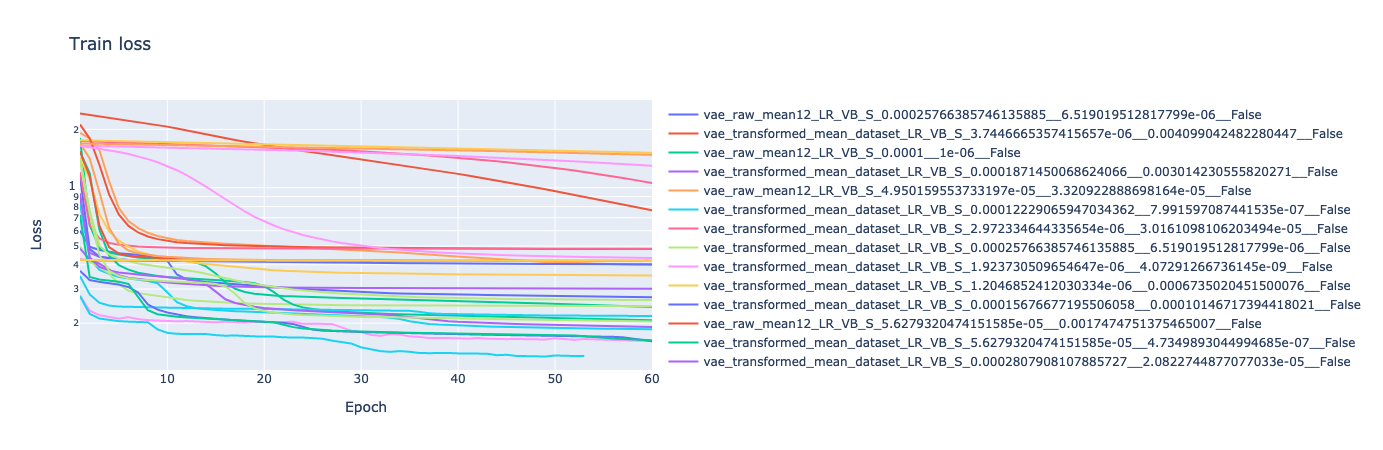

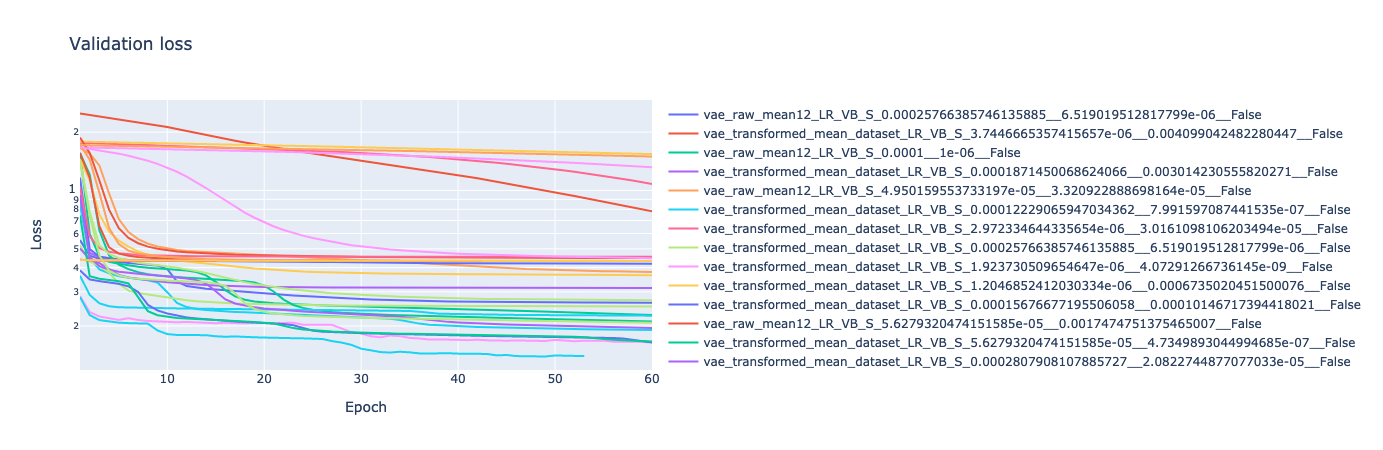

In [40]:
train_layout = go.Layout(
    title='Train loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis=dict(
        type='log'
    ),
)
fig = go.Figure(data=train_traces, layout=train_layout)
iplot(fig)

validation_layout = go.Layout(
    title='Validation loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis=dict(
        type='log'
    ),
)
fig = go.Figure(data=validation_traces, layout=validation_layout)
iplot(fig)


In [41]:
all_epochs = set()
for v in train_losses.values():
    all_epochs |= set(v.keys())

train_metrics_by_epoch = dict()
validation_metrics_by_epoch = dict()
for epoch in all_epochs:
    train_metrics_by_epoch[epoch] = dict()
    validation_metrics_by_epoch[epoch] = dict()
    for (k_train, v_train), (k_validation, v_validation) in zip(train_losses.items(), 
                                                                validation_losses.items()):
        assert k_train == k_validation
        vv_train = v_train[epoch] if epoch in v_train else None
        vv_validation = v_validation[epoch] if epoch in v_validation else None
        if vv_train is not None:
            train_metrics_by_epoch[epoch][k_train] = vv_train
        if vv_validation is not None:
            validation_metrics_by_epoch[epoch][k_validation] = vv_validation

#%%

# x and y are items of a dictionary, each of the values is either a float either None
# we sort the float ascendingly, and we consider the None as higher that every other value
l = lambda d: {k: {kk: vv for kk, vv in sorted(v.items(), key=lambda x: x[1])} for k, v in d.items()}
sorted_train = l(train_metrics_by_epoch)
sorted_validation = l(validation_metrics_by_epoch)

#%%

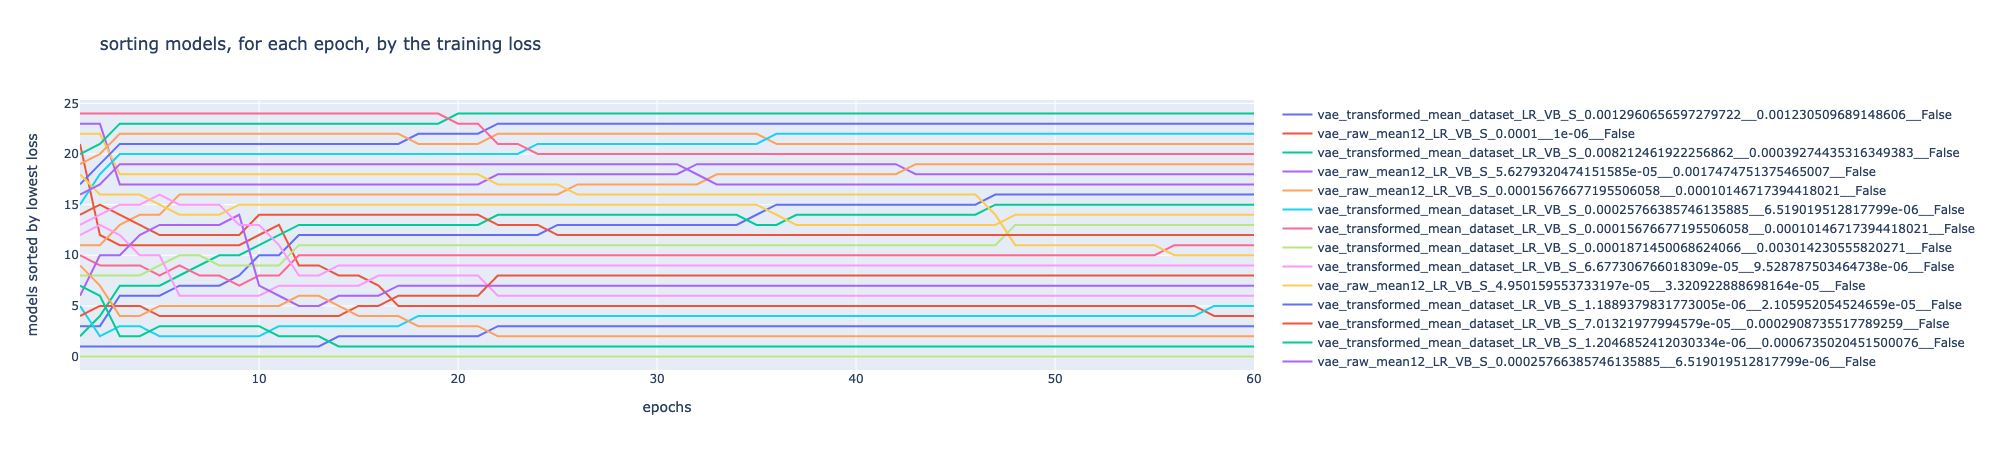

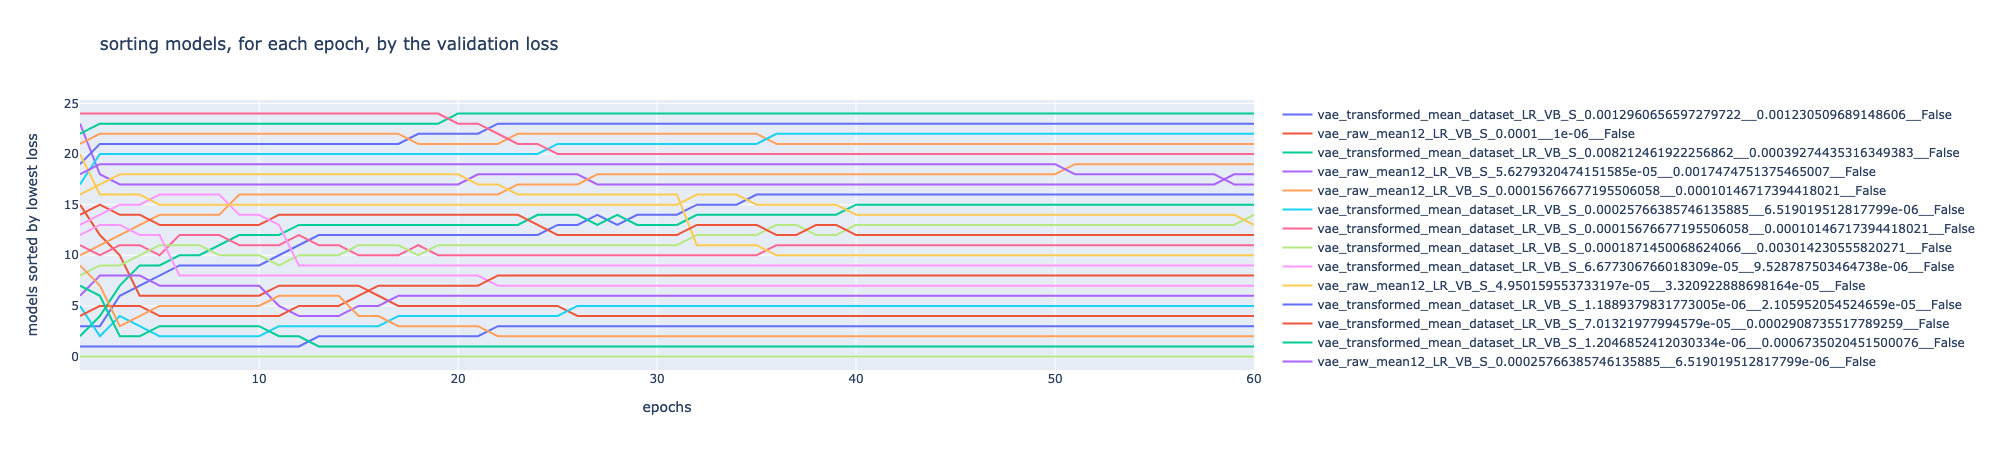

In [7]:
def plot_dict_of_sorted_metrics(d, loss_type):
    all_names = set()
    for v in d.values():
        names = set(v.keys())
        all_names |= names
    traces = {name: dict() for name in all_names}
    custom_data = {name: dict() for name in all_names}
    for epoch, sorted_names in d.items():
        for name in all_names:
            l = list(sorted_names.keys())
            if name in l:
                i = l.index(name)
                traces[name][epoch] = i
                custom_data[name][epoch] = sorted_names[name]
            
#     plt.figure(figsize=(16, 0.5 * len(all_names)))
    plotly_traces = []
    for name, trace in traces.items():
        x = list(trace.keys())
        y = list(trace.values())
        customdata = np.array(list(custom_data[name].values()))
        plotly_trace = go.Scatter(x=x, y=y, customdata=customdata, name=name, visible=visible, hovertemplate = '(%{x}, %{y}) loss: %{customdata:10.3e}')
        plotly_traces.append(plotly_trace)
#         plt.plot(x, y, label=name, linewidth=5)        
#     plt.legend()
#     plt.title(f'sorting models by {loss_type} loss, for each epoch')
#     plt.xlabel('epochs')
#     plt.ylabel('models sorted by lowest loss')
#     plt.show()
    layout = go.Layout(
        title=f'sorting models, for each epoch, by the {loss_type} loss',
        xaxis_title='epochs',
        yaxis_title='models sorted by lowest loss',      
    )
    fig = go.Figure(data=plotly_traces, layout=layout)
    iplot(fig)
    
from collections import OrderedDict
sorted_train = OrderedDict(sorted(sorted_train.items()))
sorted_validation = OrderedDict(sorted(sorted_validation.items()))
    
plot_dict_of_sorted_metrics(sorted_train, 'training')
plot_dict_of_sorted_metrics(sorted_validation, 'validation')

In [8]:
#%%

import itertools

# BE CAREFUL that if some models have not been trained until the last epoch, they could end up not being considered here while still being good models
epoch = max(sorted_validation.keys())
assert epoch == 60
candidates = list(itertools.islice(sorted_validation[epoch].items(), 10))
pprint(candidates)
instances_names = [candidate[0] for candidate in candidates]
print(instances_names)

[('vae_transformed_mean_dataset_LR_VB_S_0.007155682161754859__4.831596208381855e-07__False',
  array(0.16465825)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.00012229065947034362__7.991597087441535e-07__False',
  array(0.19065381)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False',
  array(0.19558309)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__5.038072794440208e-06__False',
  array(0.22615265)),
 ('vae_raw_mean12_LR_VB_S_0.0001__1e-06__False', array(0.22808755)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False',
  array(0.25243319)),
 ('vae_raw_mean12_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False',
  array(0.26370284)),
 ('vae_transformed_mean_dataset_LR_VB_S_6.677306766018309e-05__9.528787503464738e-06__False',
  array(0.27121421)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.0002807908107885727__2.0822744877077033e-05__False',
  array(0.3136713)),
 ('vae_transformed_mean_dataset_LR_VB_S_4.9501

In [9]:
import pickle

from data import RawMeanDataset, RawMean12, NatureBImproved, NatureBOriginal, TransformedMeanDataset

class A:
    def __init__(self, model, model_id):
        self.model = model
        self.model_id = model_id
        self.instance = model + '_' + model_id
        if self.model_id == 'raw_mean_dataset':
            self.dataset = RawMeanDataset
        elif self.model_id == 'raw_mean12':
            self.dataset = RawMean12
        elif self.model_id == 'nature_b_improved':
            self.dataset = NatureBImproved
        elif self.model_id == 'nature_b_original':
            self.dataset = NatureBOriginal
        elif self.model_id == 'transformed_mean_dataset':
            self.dataset = TransformedMeanDataset
        else:
            raise ValueError(self.instance)
        self.ds_train = self.dataset('train')
        self.ds_validation = self.dataset('validation')

normalization_methods = {'vae_raw_mean12': A('vae', 'raw_mean12'), 'vae_transformed_mean_dataset': A('vae', 'transformed_mean_dataset')}

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [10]:
import h5py
from data import file_path
from tqdm import tqdm

from data import file_path
def the_path(instance_folder, f):
    root = '/data/l989o/deployed/a/data/spatial_uzh_processed/a'
    assert instance_folder.startswith(root)
    return os.path.join(instance_folder, f)

def get_mean_spearman(ll):
    from scipy.stats import spearmanr
    import numpy as np

    all_k = set()
    name = os.path.basename(ll)
    normalization_method = name.split('_LR_VB_S_')[0]
    print(normalization_methods.keys())
    print(normalization_method)
    ds_train = normalization_methods[normalization_method].ds_train
    ds_validation = normalization_methods[normalization_method].ds_validation
    f = the_path(ll, 'embedding_train.hdf5')
    with h5py.File(f, 'r') as f5:
        assert len(f5.keys()) == 1
        k, v = f5.items().__iter__().__next__()
        if len(all_k) == 0:
            bbb = True
        all_k.add(k)
        assert len(all_k) <= 1
        if bbb:
            print(f'EPOCH {k}')

        o_train = ds_train.filenames        
        spearman_train_list = []
        for i, o in enumerate(tqdm(o_train, desc='spearamn train')):
            original = ds_train[i].numpy()
            reconstructed = v[o]['reconstructed'][...]
            assert original.shape == reconstructed.shape
            correlations = []
            for c in range(39):
                x = original[:, c]
                y = reconstructed[:, c]
                r, p_value = spearmanr(x, y)
                correlations.append(r)
            corr = np.array(correlations).reshape((1, -1))
            spearman_train_list.append(corr)
        spearman_train = np.concatenate(spearman_train_list, axis=0)
        print(spearman_train.shape)
#            instance.spearman_train = spearman_train

    f = the_path(ll, 'embedding_validation.hdf5')
    with h5py.File(f, 'r') as f5:
        assert len(f5.keys()) == 1
        k, v = f5.items().__iter__().__next__()
        if len(all_k) == 0:
            bbb = True
        all_k.add(k)
        assert len(all_k) <= 1
        if bbb:
            print(f'EPOCH {k}')

        o_validation = ds_validation.filenames        
        spearman_validation_list = []
        for i, o in enumerate(tqdm(o_validation, desc='spearamn validation')):
            original = ds_validation[i].numpy()
            reconstructed = v[o]['reconstructed'][...]
            assert original.shape == reconstructed.shape
            correlations = []
            for c in range(39):
                x = original[:, c]
                y = reconstructed[:, c]
                r, p_value = spearmanr(x, y)
                correlations.append(r)
            corr = np.array(correlations).reshape((1, -1))
            spearman_validation_list.append(corr)
        spearman_validation = np.concatenate(spearman_validation_list, axis=0)
        print(spearman_validation.shape)
#           instance.spearman_validation = spearman_validation
    return np.mean(spearman_train), np.mean(spearman_validation)

mean_spearman_dict = dict()

for ll in instances:
    r_train, r_validation = get_mean_spearman(ll)
    mean_spearman_dict[os.path.basename(ll)] = (r_train, r_validation)
print(mean_spearman_dict)
#%%

spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.46it/s]

dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_raw_mean12
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.02it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.89it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:05, 21.41it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.39it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_raw_mean12
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.61it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.61it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 27.84it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.16it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_raw_mean12
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.31it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.50it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.88it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.80it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 24.57it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.74it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.58it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.81it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.72it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.61it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 27.86it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.97it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 25.54it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.13it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_raw_mean12
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.60it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.45it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 27.99it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.81it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.13it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.63it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.89it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.59it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_raw_mean12
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:03, 29.64it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.49it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.52it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.46it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.71it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.73it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.72it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.52it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.56it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.52it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.60it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 24.84it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.41it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.13it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.37it/s]

(215, 39)
EPOCH epoch60


spearamn train:   1%|▏         | 3/215 [00:00<00:08, 25.82it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:   3%|▎         | 3/119 [00:00<00:04, 28.48it/s]

(215, 39)
EPOCH epoch60


spearamn train:   0%|          | 0/215 [00:00<?, ?it/s]/data/l989o/miniconda3/envs/spatial_uzh_test/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

spearamn train:   5%|▍         | 10/215 [00:00<00:02, 95.21it/s]

(119, 39)
dict_keys(['vae_raw_mean12', 'vae_transformed_mean_dataset'])
vae_transformed_mean_dataset
EPOCH epoch60


spearamn validation:  13%|█▎        | 15/119 [00:00<00:00, 140.02it/s]

(215, 39)
EPOCH epoch60


spearamn validation: 100%|██████████| 119/119 [00:00<00:00, 134.25it/s]

(119, 39)
{'vae_raw_mean12_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False': (0.5688702350922469, 0.5622456491734252), 'vae_transformed_mean_dataset_LR_VB_S_3.7446665357415657e-06__0.004099042482280447__False': (-0.000576727078978186, -0.0009633956210927173), 'vae_raw_mean12_LR_VB_S_0.0001__1e-06__False': (0.6044907100704954, 0.5982584144760736), 'vae_transformed_mean_dataset_LR_VB_S_0.0001871450068624066__0.003014230555820271__False': (0.00020910073629702548, -0.001029626172779663), 'vae_raw_mean12_LR_VB_S_4.950159553733197e-05__3.320922888698164e-05__False': (0.3423607165499422, 0.33698978890196074), 'vae_transformed_mean_dataset_LR_VB_S_0.00012229065947034362__7.991597087441535e-07__False': (0.6808310964859152, 0.6779395938813771), 'vae_transformed_mean_dataset_LR_VB_S_2.972334644335654e-06__3.0161098106203494e-05__False': (0.13517743970878326, 0.13358583956067663), 'vae_transformed_mean_dataset_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False': (0.619466388

In [11]:
import pandas as pd

# note: epochs is not to be taken from the instance hyperparameters, but from the training logger hdf5
# parallel_df = pd.DataFrame(columns=['epochs', 'model_name', 'normalization_method', 'vae_beta', 'vae_latent_dimensions', 'training_loss', 'validation_loss', 'mean_spearman',
#                                     'instance_hash', 'instance_name']).set_index(['instance_name'])
parallel_df = pd.DataFrame(columns=['epoch', 'normalization_method', 'vae_beta', 'training_loss', 'validation_loss', 'mean_spearman_train', 'mean_spearman_validation',
                                    'instance_name']).set_index(['instance_name'])
for ll in instances:
    name = os.path.basename(ll)
    print(name)
    normalization_method, values = name.split('_LR_VB_S_')
    learning_rate, vae_beta, scheduling_lr = values.split('__')
    
    learning_rate = float(learning_rate)
    vae_beta = float(vae_beta)
    scheduling_lr = bool(scheduling_lr)

    with h5py.File(os.path.join(ll, 'training_logger.hdf5'), 'r') as f5:
        keys = f5.keys()
        epochs = sorted([int(k.split('epoch')[1]) for k in keys])
        latest_epoch = max(epochs)
        training_loss = f5[f'epoch{latest_epoch}/training_evaluator']['loss'][...].item()
        validation_loss = f5[f'epoch{latest_epoch}/validation_evaluator']['loss'][...].item()
    row = {
        'epoch': latest_epoch,
        'model_name': name,
        'normalization_method': normalization_method,
        'vae_beta': vae_beta,
#         'vae_latent_dimensions': instance.vae_latent_dimensions,
        'learning_rate': learning_rate,
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'mean_spearman_train': mean_spearman_dict[name][0],
        'mean_spearman_validation': mean_spearman_dict[name][1]
    }
    parallel_df.loc[name, row.keys()] = list(row.values())
# parallel_df = parallel_df.append(rows)
display(parallel_df)

vae_raw_mean12_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False
vae_transformed_mean_dataset_LR_VB_S_3.7446665357415657e-06__0.004099042482280447__False
vae_raw_mean12_LR_VB_S_0.0001__1e-06__False
vae_transformed_mean_dataset_LR_VB_S_0.0001871450068624066__0.003014230555820271__False
vae_raw_mean12_LR_VB_S_4.950159553733197e-05__3.320922888698164e-05__False
vae_transformed_mean_dataset_LR_VB_S_0.00012229065947034362__7.991597087441535e-07__False
vae_transformed_mean_dataset_LR_VB_S_2.972334644335654e-06__3.0161098106203494e-05__False
vae_transformed_mean_dataset_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False
vae_transformed_mean_dataset_LR_VB_S_1.923730509654647e-06__4.07291266736145e-09__False
vae_transformed_mean_dataset_LR_VB_S_1.2046852412030334e-06__0.0006735020451500076__False
vae_transformed_mean_dataset_LR_VB_S_0.00015676677195506058__0.00010146717394418021__False
vae_raw_mean12_LR_VB_S_5.6279320474151585e-05__0.0017474751375465007__False
vae_transform

,epoch,normalization_method,vae_beta,training_loss,validation_loss,mean_spearman_train,mean_spearman_validation,model_name,learning_rate
instance_name,,,,,,,,,
vae_raw_mean12_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False,60,vae_raw_mean12,6.51902e-06,0.27229,0.263703,0.56887,0.562246,vae_raw_mean12_LR_VB_S_0.00025766385746135885_...,0.000258
vae_transformed_mean_dataset_LR_VB_S_3.7446665357415657e-06__0.004099042482280447__False,60,vae_transformed_mean_dataset,0.00409904,0.765546,0.78159,-0.000576727,-0.000963396,vae_transformed_mean_dataset_LR_VB_S_3.7446665...,0.000004
vae_raw_mean12_LR_VB_S_0.0001__1e-06__False,60,vae_raw_mean12,1e-06,0.242427,0.228088,0.604491,0.598258,vae_raw_mean12_LR_VB_S_0.0001__1e-06__False,0.000100
vae_transformed_mean_dataset_LR_VB_S_0.0001871450068624066__0.003014230555820271__False,60,vae_transformed_mean_dataset,0.00301423,0.418654,0.432513,0.000209101,-0.00102963,vae_transformed_mean_dataset_LR_VB_S_0.0001871...,0.000187
vae_raw_mean12_LR_VB_S_4.950159553733197e-05__3.320922888698164e-05__False,60,vae_raw_mean12,3.32092e-05,0.39857,0.380221,0.342361,0.33699,vae_raw_mean12_LR_VB_S_4.950159553733197e-05__...,0.000050
vae_transformed_mean_dataset_LR_VB_S_0.00012229065947034362__7.991597087441535e-07__False,60,vae_transformed_mean_dataset,7.9916e-07,0.185973,0.190654,0.680831,0.67794,vae_transformed_mean_dataset_LR_VB_S_0.0001222...,0.000122
vae_transformed_mean_dataset_LR_VB_S_2.972334644335654e-06__3.0161098106203494e-05__False,60,vae_transformed_mean_dataset,3.01611e-05,1.05732,1.08093,0.135177,0.133586,vae_transformed_mean_dataset_LR_VB_S_2.9723346...,0.000003
vae_transformed_mean_dataset_LR_VB_S_0.00025766385746135885__6.519019512817799e-06__False,60,vae_transformed_mean_dataset,6.51902e-06,0.244717,0.252433,0.619466,0.621221,vae_transformed_mean_dataset_LR_VB_S_0.0002576...,0.000258
vae_transformed_mean_dataset_LR_VB_S_1.923730509654647e-06__4.07291266736145e-09__False,60,vae_transformed_mean_dataset,4.07291e-09,1.29826,1.31757,0.0140768,0.0150186,vae_transformed_mean_dataset_LR_VB_S_1.9237305...,0.000002


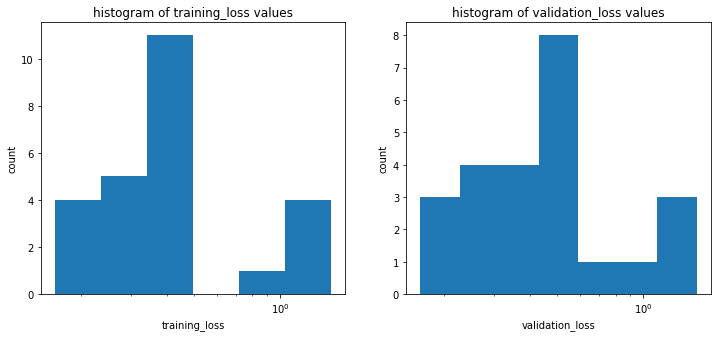

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
data = parallel_df['training_loss'].tolist()
_, bins = np.histogram(np.log10(data), bins='auto')
plt.hist(data, bins=10 ** bins)
plt.gca().set_xscale('log')
plt.title(f'histogram of training_loss values')
plt.xlabel('training_loss')
plt.ylabel('count')
training_bins = 10 ** bins

plt.subplot(1, 2, 2)
data = parallel_df['validation_loss'].tolist()
_, bins = np.histogram(np.log10(data), bins='auto')
plt.hist(data, bins=10 ** bins)
plt.gca().set_xscale('log')
plt.title(f'histogram of validation_loss values')
plt.xlabel('validation_loss')
plt.ylabel('count')
validation_bins = 10 ** bins

plt.show()

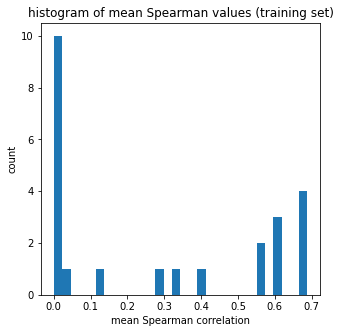

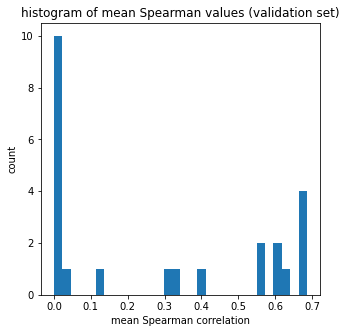

In [13]:
#%%

v = parallel_df['mean_spearman_train'].dropna()
plt.figure(figsize=(5, 5))
_, spearman_train_bins, _ = plt.hist(v, bins=30)
plt.title('histogram of mean Spearman values (training set)')
plt.xlabel('mean Spearman correlation')
plt.ylabel('count')
plt.show()

v = parallel_df['mean_spearman_validation'].dropna()
plt.figure(figsize=(5, 5))
_, spearman_validation_bins, _ = plt.hist(v, bins=30)
plt.title('histogram of mean Spearman values (validation set)')
plt.xlabel('mean Spearman correlation')
plt.ylabel('count')
plt.show()

In [14]:
#%%

print(training_bins)
print(validation_bins)
print(spearman_train_bins)
print(spearman_validation_bins)

[0.16140101 0.23448476 0.34066145 0.49491584 0.71901794 1.04459538
 1.51759704]
[0.16465825 0.22661902 0.31189559 0.42926166 0.5907925  0.81310727
 1.11907892 1.54018746]
[-0.000576727078978186 0.02238885756195833 0.04535444220289485
 0.06832002684383137 0.09128561148476788 0.11425119612570439
 0.13721678076664093 0.16018236540757744 0.18314795004851395
 0.20611353468945046 0.22907911933038697 0.25204470397132345
 0.27501028861226 0.2979758732531965 0.32094145789413303
 0.34390704253506954 0.36687262717600605 0.38983821181694256
 0.41280379645787907 0.4357693810988156 0.4587349657397521
 0.48170055038068865 0.5046661350216252 0.5276317196625617
 0.5505973043034983 0.5735628889444347 0.5965284735853713
 0.6194940582263078 0.6424596428672443 0.6654252275081808
 0.6883908121491173]
[-0.001029626172779663 0.02190688509632746 0.044843396365434586
 0.06777990763454173 0.09071641890364884 0.11365293017275596
 0.1365894414418631 0.15952595271097023 0.18246246398007734
 0.20539897524918446 0.22

In [15]:
def match_bin(x, bins, exp_notation=True):
    precision_error0 = False
    precision_error1 = False
    if not (bins[0] <= x <= bins[-1]):
        # we are probably here due to a rounding error when bins are computed as 10 ** bins, let's check that this is the case
        r0 = abs(bins[0] - x) / bins[0]
        r1 = abs(bins[-1] - x) / bins[-1]
        eps = 1e-6
        if r0 < eps:
            precision_error0 = True
        if r1 < eps:
            precision_error1 = True
        # xor
        assert precision_error0 != precision_error1 
    n = len(bins)
    for i in range(n - 1):
        a = bins[i]
        b = bins[i + 1]
        if a <= x <= b:
            if exp_notation:
                s = f'{a:.2e} - {b:.2e}'
            else:
                s = f'{a:.02f} - {b:.02f}'
            return s, i
    assert precision_error0 != precision_error1
    if precision_error0:
        i = 0
    else:
        i = n - 2
    if exp_notation:
        s = f'{bins[i]:.2e} - {bins[i + 1]:.2e}'
    else:
        s = f'{bins[i]:.02f} - {bins[i + 1]:.02f}'
#     print(f'match_bin({x}, {bins}, {exp_notation}) -> ({s}, {n - 1})')
#     print(f'len(bins) = {len(bins)}')
    return s, n - 1

In [16]:
#%%

import re

def hex_to_rgb(hx, hsl=False):
    """Converts a HEX code into RGB or HSL.
    Args:
        hx (str): Takes both short as well as long HEX codes.
        hsl (bool): Converts the given HEX code into HSL value if True.
    Return:
        Tuple of length 3 consisting of either int or float values."""
    if re.compile(r'#[a-fA-F0-9]{3}(?:[a-fA-F0-9]{3})?$').match(hx):
        div = 255.0 if hsl else 0
        if len(hx) <= 4:
            return tuple(int(hx[i]*2, 16) / div if div else
                         int(hx[i]*2, 16) for i in (1, 2, 3))
        else:
            return tuple(int(hx[i:i+2], 16) / div if div else
                         int(hx[i:i+2], 16) for i in (1, 3, 5))
    else:
        raise ValueError(f'"{hx}" is not a valid HEX code.')

#%%

In [17]:
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.express as px
import matplotlib.colors
import matplotlib.cm

parallel_df.sort_values(by=['validation_loss', 'vae_beta'], ascending=[False, True], inplace=True)  #, 'vae_latent_dimensions' , False
parallel_df['binned_validation_loss'] = parallel_df['validation_loss'].apply(lambda x: match_bin(x, validation_bins)[0])
parallel_df['binned_training_loss'] = parallel_df['training_loss'].apply(lambda x: match_bin(x, training_bins)[0])
parallel_df['binned_mean_spearman_train'] = parallel_df['mean_spearman_train'].apply(lambda x: match_bin(x, spearman_train_bins, exp_notation=False)[0])
parallel_df['binned_mean_spearman_validation'] = parallel_df['mean_spearman_validation'].apply(lambda x: match_bin(x, spearman_validation_bins, exp_notation=False)[0])

AssertionError: 

In [ ]:
parallel_df

In [ ]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
# validation_bin_colors = mapper.to_rgba(np.linspace(0, 1, len(validation_bins) - 1))
validation_bin_colors = mapper.to_rgba(np.linspace(0, 1, len(validation_bins)))
colors = parallel_df['validation_loss'].apply(lambda x: validation_bin_colors[match_bin(x, validation_bins)[1]]).tolist()
colors = [tuple(color)[:3] for color in colors]
# print(colors)
colors = px.colors.sequential.Viridis_r
colors = [f'rgba{hex_to_rgb(c) + (1, )}' for c in colors]
# 'vae_latent_dimensions'
columns = ['model_name', 'normalization_method', 'epoch', 'vae_beta', 'learning_rate', 'binned_training_loss', 'binned_validation_loss', 'binned_mean_spearman_train', 'binned_mean_spearman_validation']
fig = px.parallel_categories(parallel_df, dimensions=columns,
                             color=np.log10(parallel_df['validation_loss'].tolist()),
#                 color='binned_validation_loss',
                             color_continuous_scale=colors,
#                 labels={'transformation': 'Transformation', 'centering': 'Centering', 'n_hidden_layers': '# hidden layers', 'validation_accuracy': 'Validation accuracy'},
                             title='Effect of the hyperparameters on the model performance')
# pprint(sorted(fig.__dir__()))
fig.update_layout(
    autosize=False,
    width=1600,
    height=900,
    coloraxis_colorbar=dict(title='Validation loss'),
#     width=2500,
#     height=1500
)

# change this path to what fits your machine!
# fig.write_image(paths_uzh.jupyter_plot('parallel_categories.png'))
fig.show()

In [ ]:
#%%

import plotly.graph_objects as go

# Create dimensions
dimensions = []

sorted_names = list(reversed(parallel_df.reset_index('instance_name')['instance_name'].tolist()))
dimensions.append(go.parcats.Dimension(
    values=parallel_df.reset_index('instance_name')['instance_name'],
    categoryorder='array',
    categoryarray=sorted_names,
    label='Instance name'
))

# dimensions.append(go.parcats.Dimension(
#     values=parallel_df['model_name'],
#     categoryorder='array',
#     categoryarray=sorted(list(set(parallel_df['model_name'].tolist()))),
#     label='Model name'
# ))

dimensions.append(go.parcats.Dimension(
    values=parallel_df['normalization_method'],
    categoryorder='array',
    categoryarray=sorted(list(set(parallel_df['normalization_method'].tolist()))),
    label='Normalization method'
))

# dimensions.append(go.parcats.Dimension(
#     values=parallel_df['epochs'],
#     categoryorder='array',
#     categoryarray=sorted(list(set(parallel_df['epochs'].tolist()))),
#     label='Epochs'
# ))

# dimensions.append(go.parcats.Dimension(
#     values=parallel_df['vae_latent_dimensions'],
#     categoryorder='array',
#     categoryarray=sorted(list(set(parallel_df['vae_latent_dimensions'].tolist()))),
#     label='VAE latent dimensions'
# ))

ordered_bin_labels = lambda bins, exp_notation=True: [match_bin(np.mean((bins[i], bins[i + 1])), bins, exp_notation)[0] for i in range(len(bins) - 1)]

training_labels = [s for s in reversed(ordered_bin_labels(training_bins)) if s in parallel_df['binned_training_loss'].tolist()]
dimensions.append(go.parcats.Dimension(
    values=parallel_df['binned_training_loss'],
    categoryorder='array',
    categoryarray=training_labels,
    label='Training loss'
))

validation_labels = [s for s in reversed(ordered_bin_labels(validation_bins)) if s in parallel_df['binned_validation_loss'].tolist()]
dimensions.append(go.parcats.Dimension(
    values=parallel_df['binned_validation_loss'],
    categoryorder='array',
    categoryarray=validation_labels,
    label='Validation loss'
))

spearman_train_labels = [s for s in ordered_bin_labels(spearman_train_bins, exp_notation=False) if s in parallel_df['binned_mean_spearman_train'].tolist()]
dimensions.append(go.parcats.Dimension(
    values=parallel_df['binned_mean_spearman_train'],
    categoryorder='array',
    categoryarray=spearman_train_labels,
    label='Mean Spearman train'
))

spearman_validation_labels = [s for s in ordered_bin_labels(spearman_validation_bins, exp_notation=False) if s in parallel_df['binned_mean_spearman_validation'].tolist()]
dimensions.append(go.parcats.Dimension(
    values=parallel_df['binned_mean_spearman_validation'],
    categoryorder='array',
    categoryarray=spearman_validation_labels,
    label='Mean Spearman validation'
))

l = sorted(list(set(parallel_df['vae_beta'].tolist())))
l = [f'{ll:.2e}' for ll in l]
dimensions.append(go.parcats.Dimension(
    values=parallel_df['vae_beta'].apply(lambda x: f'{x:.2e}'),
    categoryorder='array',
    categoryarray=l,
    label='VAE beta'
))

l = sorted(list(set(parallel_df['learning_rate'].tolist())))
l = [f'{ll:.2e}' for ll in l]
dimensions.append(go.parcats.Dimension(
    values=parallel_df['learning_rate'].apply(lambda x: f'{x:.2e}'),
    categoryorder='array',
    categoryarray=l,
    label='Learning rate'
))

color = np.log(parallel_df['validation_loss'].tolist());
colors = px.colors.sequential.Viridis_r
colorscale = [[x, c] for x, c in zip(np.linspace(0, 1, len(colors)), colors)]
# print(colorscale)
# [[0, 'lightsteelblue'], [1, 'mediumseagreen']];

fig = go.Figure(data = [go.Parcats(
    dimensions=dimensions,
    line={'color': color, 'colorscale': colorscale},
    hoveron='color', #hoverinfo='count+model_name',
# TODO: I can't set customdata, I would like to put the (non-binned) validation loss, training loss, mean spearman, instance hash and instance name
#         customdata=parallel_df['training_loss'].tolist(),
#         hovertemplate='<br>z2:%{customdata[0]:.3f} <br>z3: %{customdata[1]:.3f} ',
    labelfont={'size': 10}, #, 'family': 'Times'},
    tickfont={'size': 10}, #, 'family': 'Times'},
    arrangement='freeform'
)])

fig.update_layout(
    autosize=False,
    width=1600,
    height=900,
    coloraxis_colorbar=dict(title='Validation loss')
)
fig.show()

#%%

In [ ]:
parallel_df

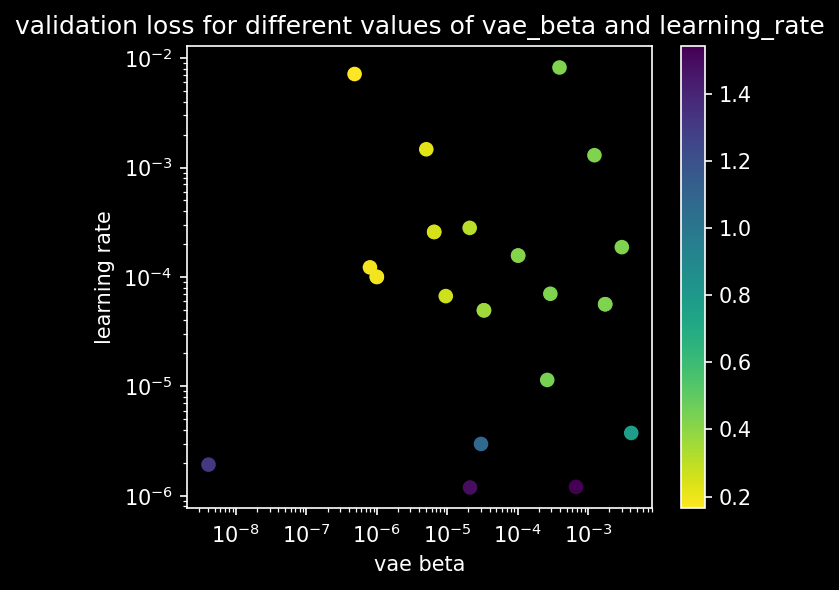

In [30]:
import seaborn as sns

plt.style.use('dark_background')
plt.figure(figsize=(5, 4), dpi=150)
# sns.set_palette(sns.color_palette('viridis'))
# sns.scatterplot(x='vae_beta', y='learning_rate', hue='validation_loss', data=parallel_df, palette='viridis_r', linewidth=0)
plt.scatter(x=parallel_df['vae_beta'], y=parallel_df['learning_rate'], c=parallel_df['validation_loss'], cmap='viridis_r')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.title('validation loss for different values of vae_beta and learning_rate')
plt.xlabel('vae beta')
plt.ylabel('learning rate')
# ax = plt.gca()
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
#           fancybox=True, shadow=True, ncol=5)
plt.show()
plt.style.use('default')

[0.01751652698276284, -0.000279278637098948, 0.33698978890196074, 0.5622456491734252, 0.5982584144760736]


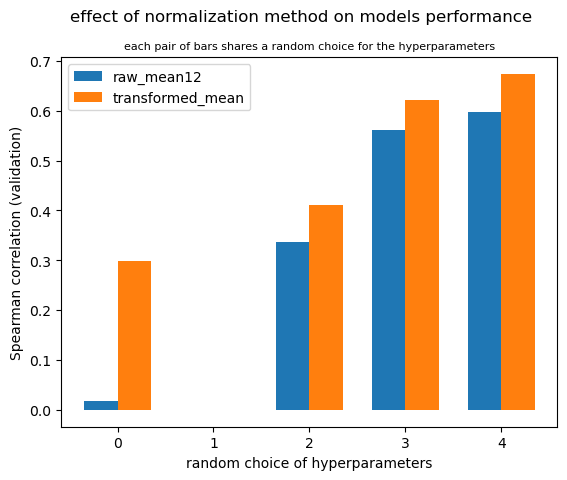

In [24]:
vae_betas = parallel_df['vae_beta'].unique().tolist()
vae_betas

bars_a = []
bars_b = []
for vb in vae_betas:
    a = parallel_df.loc[(parallel_df['normalization_method'] == 'vae_raw_mean12') & (parallel_df['vae_beta'] == vb), :]
    b = parallel_df.loc[(parallel_df['normalization_method'] == 'vae_transformed_mean_dataset') & (parallel_df['vae_beta'] == vb), :]
    if len(a) == 1 and len(b) == 1:
        bars_a.append(a.iloc[0].to_dict()['mean_spearman_validation'])
        bars_b.append(b.iloc[0].to_dict()['mean_spearman_validation'])

print(bars_a)
        
plt.figure()
x = np.arange(len(bars_a))
width = 0.35
rects1 = plt.bar(x - width / 2, bars_a, width, label='raw_mean12')
rects2 = plt.bar(x + width / 2, bars_b, width, label='transformed_mean')
plt.xlabel('random choice of hyperparameters')
plt.ylabel('Spearman correlation (validation)')
plt.suptitle('effect of normalization method on models performance')
plt.title('each pair of bars shares a random choice for the hyperparameters', fontsize=8)
plt.legend()
plt.show()